# **Initial setup**

Install Bambu and required packages:

In [ ]:
% pip install gdown
!gdown --id 1TRRbCaOeKFK83DtxQfOuGNA_ZP0RLYSG
!tar xvf dist.tar.xz -C /

In [ ]:
!apt install verilator iverilog clang-6.0 libclang-6.0-dev gcc-7-multilib libbdd-dev autoconf autoconf-archive automake libtool

In [ ]:
!git clone https://github.com/SerenaC94/bambu-tutorial.git
%cd bambu-tutorial

Edit PATH variable:

In [ ]:
%env PATH=/opt/panda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin

# **Introduction**

Have a look at the C code for **Exercise 1**: /content/bambu-tutorial/01-introduction/Exercise1/module.c

Launch bambu:

In [ ]:
% cd /content/bambu-tutorial/01-introduction/Exercise1
!bambu icrc.c --top-fname=icrc1 --simulator=VERILATOR --simulate --generate-tb=test_icrc1.xml -v2 --print-dot --pretty-print=a.c 2>&1 | tee icrc1.log

Inspect the generated files in the explorer tab on the left:

*   icrc1.v
*   test_icrc1.xml
*   simulate_icrc1.sh
*   synthesize_Synthesis_icrc1.sh



Visualize the FSM:

In [ ]:
from graphviz import Source
Source.from_file('HLS_output/dot/icrc1/HLS_STGraph.dot')

Navigate through the explorer to see the code for other exercises, **edit** this box to execute them:

In [ ]:
% cd /content/bambu-tutorial/01-introduction/Exercise2
!./bambu.sh

# **Target selection and tool integration**

**Exercise 1**: synthesize a module that returns the minimum and maximum value in an array.

Start by modifying the code below:

In [ ]:
%cd /content/bambu-tutorial/02-target_customization/Exercise1/

In [ ]:
%%writefile minmax.c
void max(int input[10], int * max)
{
   int local_max = input[0];
   int i = 0;
   for(i = 0; i < 10; i++)
   {
      if(input[i] > local_max)
      {
         local_max = input[i];
      }
   }
   *max = local_max;
}

Synthesize with bambu:

In [ ]:
!bambu minmax.c

**Exercise 2**: write a testbench to test arrays with different elemets and different sizes.

Start by modifying the code below **(change parameter names so that they correspond to function arguments in your code)**:

In [ ]:
%%writefile test.xml
<?xml version="1.0"?>
<function>
   <testbench input="{0,1,2,3,4}" num_elements="5"/>
</function>

In [ ]:
!bambu minmax.c --generate-tb=test.xml --simulate

**Exercise 3**: compare simulations across different target platforms and frequencies.

Start from the given command and modify the options appropriately to test the following combinations:


*   xc4vlx100-10ff1513 – 66MHz
*   5SGXEA7N2F45C1 – 200MHz
*   xc7vx690t-3ffg1930-VVD – 100MHz
*   xc7vx690t-3ffg1930-VVD – 333MHz
*   xc7vx690t-3ffg1930-VVD – 400MHz



In [ ]:
!bambu minmax.c --device-name=xc4vlx100-10ff1513 --clock-period=15 --simulate

# **Optimizations**

**Exercise 1**: modify Bambu options to evaluate the effect of:


*   different levels of optimization
*   vectorization
*   inlining


In [ ]:
%cd /content/bambu-tutorial/03-optimizations/Exercise1/
!bambu adpcm.c -O0 --simulate

**Exercise 2**: use the command that yielded the best result in Exercise 1 and verify if SDC scheduling can introduce further improvements.

In [ ]:
!bambu adpcm.c -O0 --simulate

**Exercise 3**: modify Bambu options to evaluate the effect of different integer division implementations.

In [ ]:
%cd /content/bambu-tutorial/03-optimizations/Exercise3/
!bambu dfdiv.c --simulate --clock-period=15 --hls-div=none

**Exercise 4**: write C functions that compute the following formula with single precision and double precision data types, experimenting with softfloat and libm implementations.

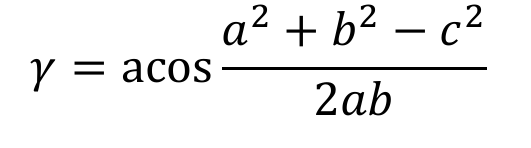

Start by editing this code and then try different bambu options:

In [ ]:
%cd /content/bambu-tutorial/03-optimizations/Exercise4/

In [ ]:
%%writefile module.c
#include <math.h>
float formula_pow(float a, float b, float c)
{
   return acosf((powf(a,2) + powf(b,2) - powf(c,2))/(2*a*b));
}

In [ ]:
!bambu module.c -O3 -lm --simulate --top-fname=formula_pow --generate-tb="a=3.0,b=4.0,c=5.0" --speculative-sdc-scheduling --libm-std-rounding --hls-div=none --soft-float

**USE THIS LATER**

In [ ]:
!git clone https://github.com/SerenaC94/bambu-tutorial.git
%cd bambu-tutorial
!tar xvf dist.tar.xz -C /